In [1]:
import xarray as xr 
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import os 
import copy
from scipy import signal
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta


import matplotlib.pyplot as plt
import matplotlib as mpl
#import collections
import matplotlib.ticker as mticker
from matplotlib import ticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.crs as ccrs
import cartopy as cart
import cartopy.mpl.ticker as cticker
import cartopy.feature as cfeature
from matplotlib.colors import ListedColormap
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cmocean
import scipy as sp
import warnings
warnings.filterwarnings("ignore")
import os
import glob
import pickle


In [2]:
f1 = '/glade/derecho/scratch/wchapman/ADF/f.e.FTORCHmjo_MEANmjo/ts/f.e.FTORCHmjo_MEANmjo.cam.h0.OMEGA.plev.197601-201012.nc'
f2 = '/glade/derecho/scratch/wchapman/ADF/f.e.FTORCHmjo_CNTRLmjo/ts/f.e.FTORCHmjo_CNTRLmjo.cam.h0.OMEGA.plev.197601-201012.nc'
f3 = '/glade/derecho/scratch/wchapman/ADF/f.e.FTORCHmjo_CNNmjo/ts/f.e.FTORCHmjo_CNNmjo.cam.h0.OMEGA.plev.197601-201012.nc'
f4 = '/glade/derecho/scratch/wchapman/ADF/f.e.FTORCHmjo_meanGPU_exp001/ts/f.e.FTORCHmjo_meanGPU_exp001.cam.h0.OMEGA.plev.197601-201012.nc'
ERAf = '/glade/campaign/cgd/amp/wchapman/Reanalysis/ERA5_obs/ERA5.an.sfc.pl.camgrid.1979-2022.nc'

DS1 = xr.open_dataset(f1)
DS2 = xr.open_dataset(f2)
DS3 = xr.open_dataset(f3)
DS4 = xr.open_dataset(f4)
DSera = xr.open_dataset(ERAf)['w'].sel(level=DS1['lev']).to_dataset(name='OMEGA')

In [3]:
DSmean_la = DS1.sel(time=slice('1979-01-01','2011-01-01')).sel(lat=slice(-5,5)).mean(['time','lat'])
DScntrl_la = DS2.sel(time=slice('1979-01-01','2011-01-01')).sel(lat=slice(-5,5)).mean(['time','lat'])
DScnn_la = DS3.sel(time=slice('1979-01-01','2011-01-01')).sel(lat=slice(-5,5)).mean(['time','lat'])
DSfullcnn_la = DS4.sel(time=slice('1979-01-01','2011-01-01')).sel(lat=slice(-5,5)).mean(['time','lat'])
DSera_la = DSera.sel(time=slice('1979-01-01','2010-12-01')).sel(lat=slice(-5,5)).mean(['time','lat'])

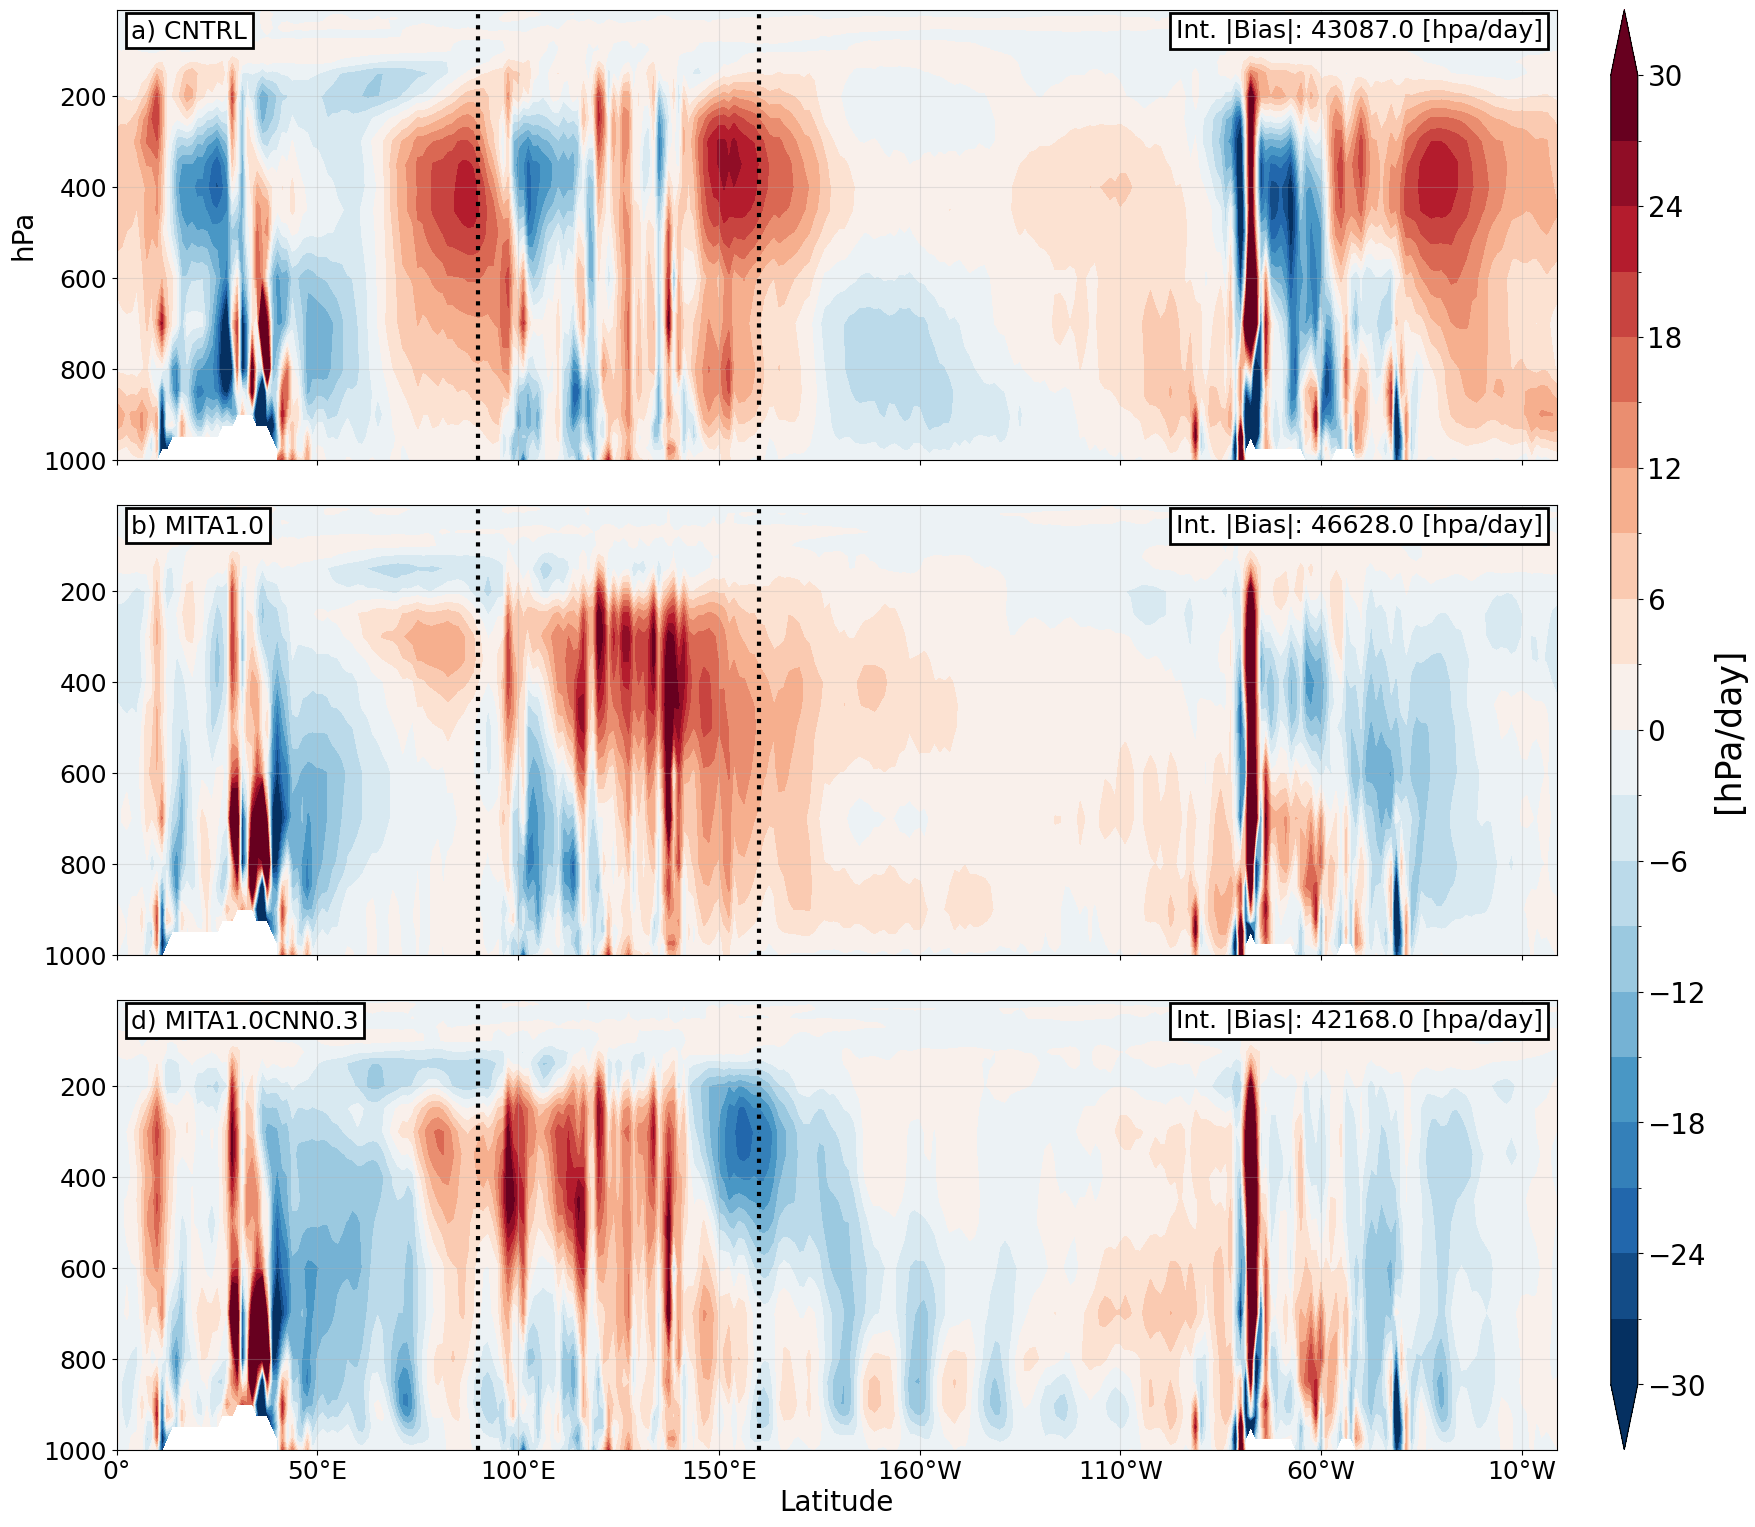

In [30]:
fig, axes = plt.subplots(3, 1, sharey=True, sharex=True, figsize=(18,18))
ax1, ax2, ax4 = axes.flatten()  # This will convert the 2x2 array into a flat array of axes


def calculate_integrated_bias(plotter, levels):
    # Calculate the vertically integrated absolute value of bias
    return np.round(np.sum(np.abs(plotter[:24, :]) * np.expand_dims(np.diff(levels), axis=1)) / 9.81, 2)


# define the colormap
cmap = plt.cm.RdBu_r
# extract all colors from the Reds map
cmaplist = [cmap(i) for i in range(cmap.N)]
# make the first color entry to be whhite
# make the last color entry to be most extreme--

cmap.N
# create the new map
cmap = cmap.from_list('My cmap', cmaplist, cmap.N)
clevels = np.arange(-30,33,3)
norm = mpl.colors.BoundaryNorm(clevels, cmap.N)


plotter = DScntrl_la['OMEGA']*864 - DSera_la['OMEGA']*864
lat =  plotter['lon']
plevv =  plotter['lev']
ff=ax1.contourf(lat,plevv,plotter,levels=clevels,cmap=cmap,norm=norm,extend='both')
ax1.plot([90,90],[1000,0],color='k',linewidth=3,linestyle=':')
ax1.plot([160,160],[1000,0],color='k',linewidth=3,linestyle=':')

integrated_bias = calculate_integrated_bias(plotter.sel(lon=slice(90,160)), DSera_la['lev'])
bbox_props = dict(fc="white", ec="k", lw=2)
ax1.text(0.99, 0.98, f'Int. |Bias|: {np.round(integrated_bias.values)} [hpa/day]', transform=ax1.transAxes, ha='right', va='top', fontsize=18, bbox=bbox_props)
ax1.text(0.01, 0.98, f'a) CNTRL', transform=ax1.transAxes, ha='left', va='top', fontsize=18, bbox=bbox_props)

ax1.grid(True, alpha=0.3)
ax1.set_ylim([10,1000])
ax1.set_ylabel('hPa',fontsize=20)
lon_formatter = LongitudeFormatter(number_format='.0f')
ax1.tick_params(labelsize=18) 
ax1.invert_yaxis()
ax1.xaxis.set_major_formatter(lon_formatter)

plotter = DSmean_la['OMEGA']*864 - DSera_la['OMEGA']*864
lat =  plotter['lon']
plevv =  plotter['lev']
ff=ax2.contourf(lat,plevv,plotter,levels=clevels,cmap=cmap,norm=norm,extend='both')
ax2.plot([90,90],[1000,0],color='k',linewidth=3,linestyle=':')
ax2.plot([160,160],[1000,0],color='k',linewidth=3,linestyle=':')

ax2.grid(True, alpha=0.3)
ax2.set_ylim([10,1000])
lon_formatter = LongitudeFormatter(number_format='.0f')
ax2.tick_params(labelsize=18) 
ax2.invert_yaxis()
ax2.xaxis.set_major_formatter(lon_formatter)
integrated_bias = calculate_integrated_bias(plotter.sel(lon=slice(90,160)), DSera_la['lev'])
bbox_props = dict(fc="white", ec="k", lw=2)
ax2.text(0.99, 0.98, f'Int. |Bias|: {np.round(integrated_bias.values)} [hpa/day]', transform=ax2.transAxes, ha='right', va='top', fontsize=18, bbox=bbox_props)
ax2.text(0.01, 0.98, f'b) MITA1.0', transform=ax2.transAxes, ha='left', va='top', fontsize=18, bbox=bbox_props)



# plotter = DScnn_la['OMEGA']*864 - DSera_la['OMEGA']*864
# lat =  plotter['lon']
# plevv =  plotter['lev']
# ff=ax3.contourf(lat,plevv,plotter,levels=clevels,cmap=cmap,norm=norm,extend='both')
# ax3.grid(True, alpha=0.3)
# ax3.set_ylim([10,1000])
# ax3.set_xlabel('Latitude',fontsize=20)
# ax3.set_ylabel('hPa',fontsize=20)
# lon_formatter = LongitudeFormatter(number_format='.0f')
# ax3.tick_params(labelsize=18) 
# ax3.invert_yaxis()
# ax3.xaxis.set_major_formatter(lon_formatter)
# integrated_bias = calculate_integrated_bias(plotter.sel(lon=slice(90,160)), DSera_la['lev'])
# bbox_props = dict(fc="white", ec="k", lw=2)
# ax3.text(0.99, 0.98, f'Int. |Bias|: {np.round(integrated_bias.values)} [hpa/day]', transform=ax3.transAxes, ha='right', va='top', fontsize=18, bbox=bbox_props)
# ax3.text(0.01, 0.98, f'c) MITA1.0MJO1.0', transform=ax3.transAxes, ha='left', va='top', fontsize=18, bbox=bbox_props)


plotter = DSfullcnn_la['OMEGA']*864 - DSera_la['OMEGA']*864
lat =  plotter['lon']
plevv =  plotter['lev']
ff=ax4.contourf(lat,plevv,plotter,levels=clevels,cmap=cmap,norm=norm,extend='both')
ax4.plot([90,90],[1000,0],color='k',linewidth=3,linestyle=':')
ax4.plot([160,160],[1000,0],color='k',linewidth=3,linestyle=':')

ax4.grid(True, alpha=0.3)
ax4.set_ylim([10,1000])
ax4.set_xlabel('Latitude',fontsize=20)
lon_formatter = LongitudeFormatter(number_format='.0f')
ax4.tick_params(labelsize=18) 
ax4.invert_yaxis()
ax4.xaxis.set_major_formatter(lon_formatter)
integrated_bias = calculate_integrated_bias(plotter.sel(lon=slice(90,160)), DSera_la['lev'])
bbox_props = dict( fc="white", ec="k", lw=2)
ax4.text(0.99, 0.98, f'Int. |Bias|: {np.round(integrated_bias.values)} [hpa/day]', transform=ax4.transAxes, ha='right', va='top', fontsize=18, bbox=bbox_props)
ax4.text(0.01, 0.98, f'd) MITA1.0CNN0.3', transform=ax4.transAxes, ha='left', va='top', fontsize=18, bbox=bbox_props)


# create the colorbar
ax5 = fig.add_axes([0.93, 0.1, 0.015, 0.8])
cb = mpl.colorbar.ColorbarBase(ax5, cmap=cmap, norm=norm, extend='both', spacing='proportional', ticks=clevels, boundaries=clevels)
ax5.set_ylabel('[hPa/day]', size=25)
cb.ax.tick_params(labelsize=20)
tick_locator = ticker.MaxNLocator(nbins=10)
cb.locator = tick_locator
cb.update_ticks()

plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.1, hspace=0.1)
plt.savefig(f'./Walker_Circulation_integrated_Bias.png', dpi=200, bbox_inches='tight')
plt.show()

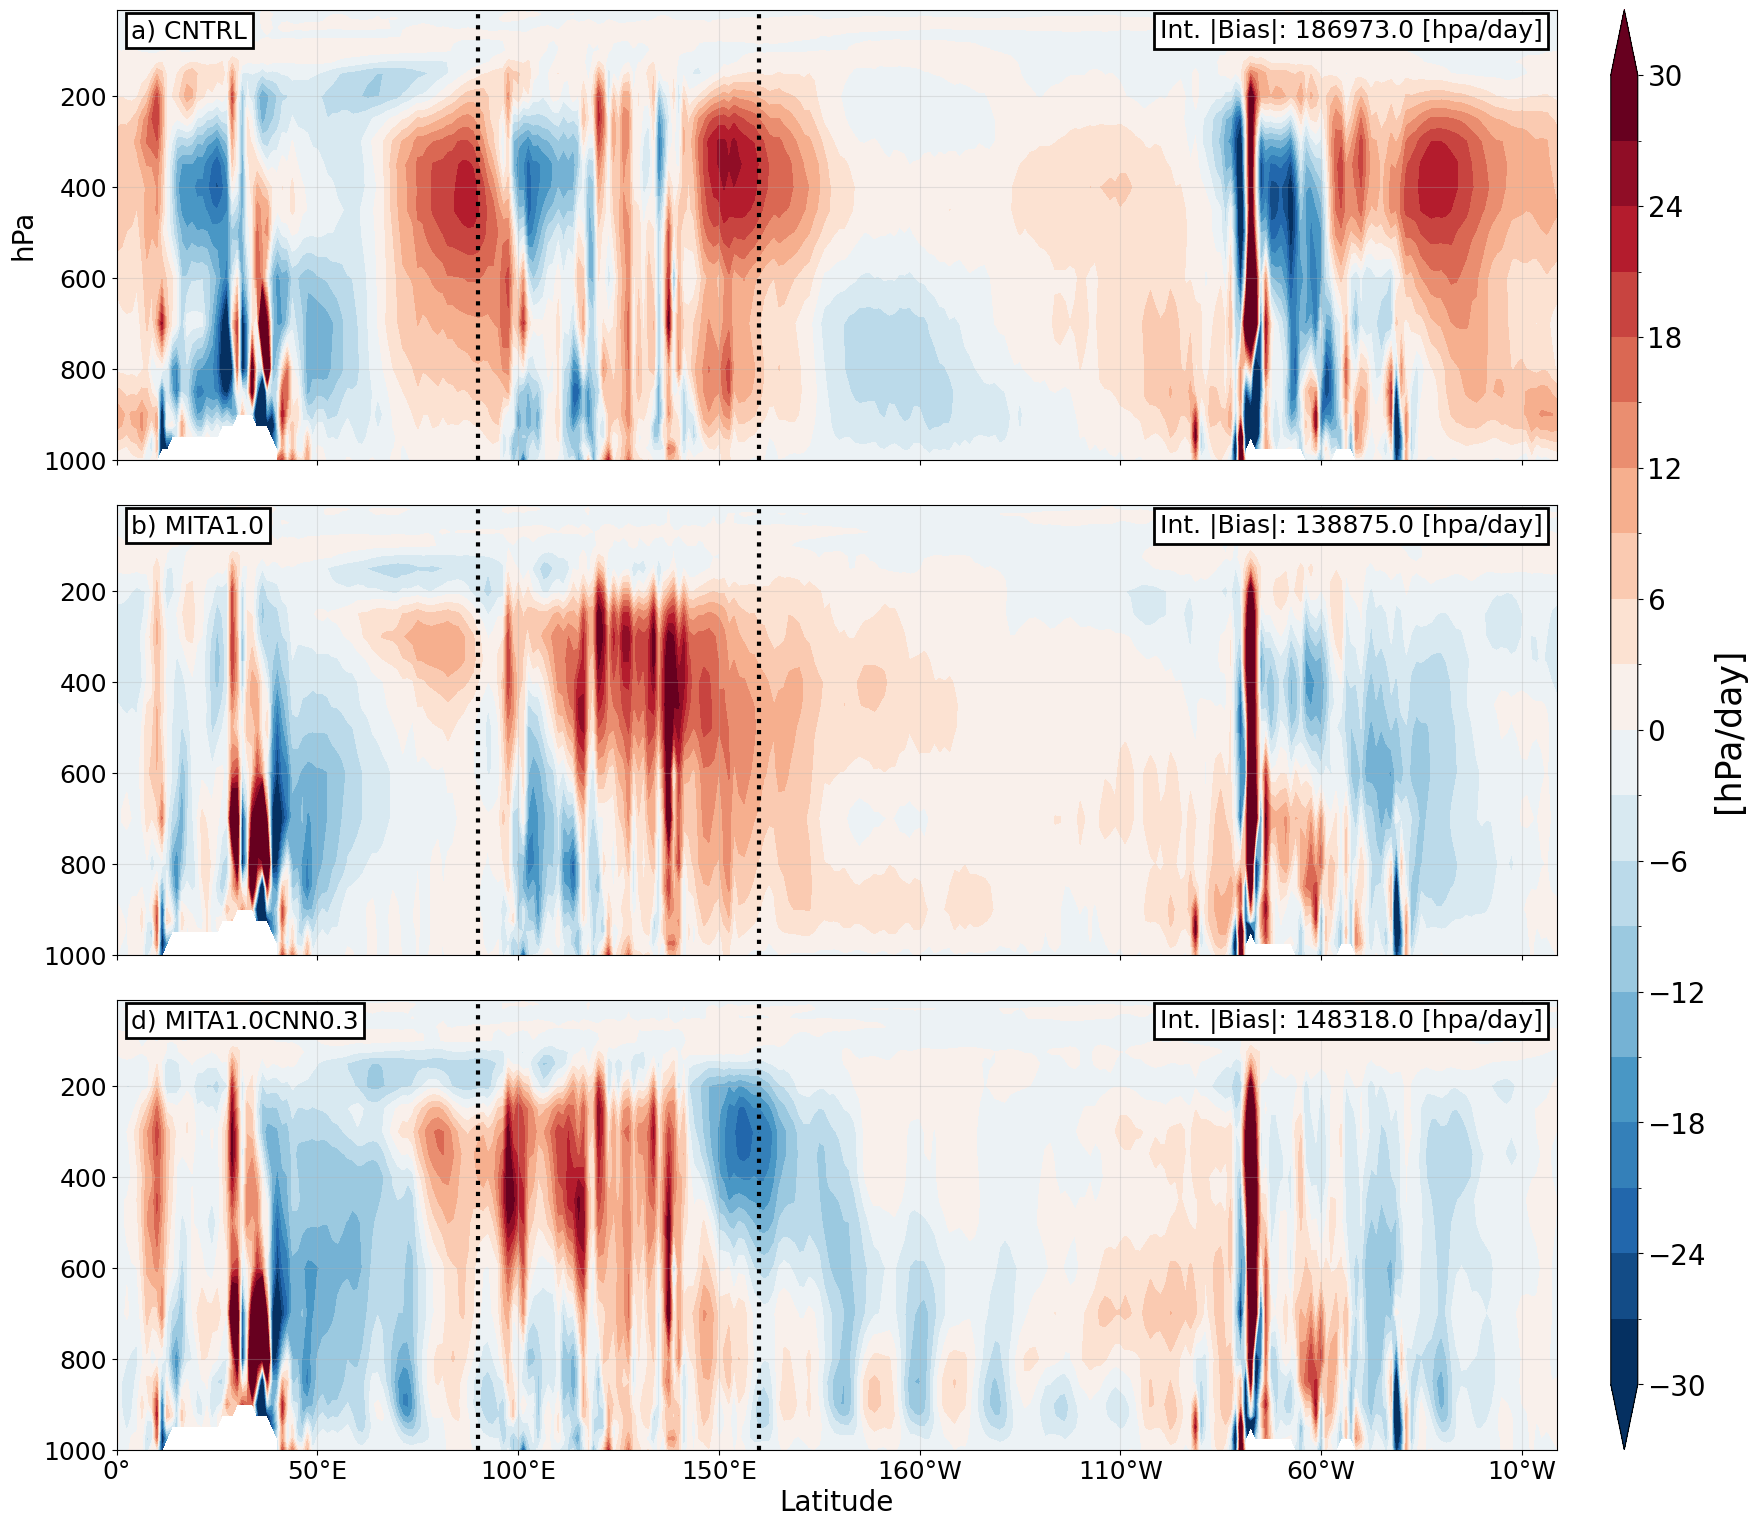

In [31]:
fig, axes = plt.subplots(3, 1, sharey=True, sharex=True, figsize=(18,18))
ax1, ax2, ax4 = axes.flatten()  # This will convert the 2x2 array into a flat array of axes


def calculate_integrated_bias(plotter, levels):
    # Calculate the vertically integrated absolute value of bias
    return np.round(np.sum(np.abs(plotter[:24, :]) * np.expand_dims(np.diff(levels), axis=1)) / 9.81, 2)


# define the colormap
cmap = plt.cm.RdBu_r
# extract all colors from the Reds map
cmaplist = [cmap(i) for i in range(cmap.N)]
# make the first color entry to be whhite
# make the last color entry to be most extreme--

cmap.N
# create the new map
cmap = cmap.from_list('My cmap', cmaplist, cmap.N)
clevels = np.arange(-30,33,3)
norm = mpl.colors.BoundaryNorm(clevels, cmap.N)


plotter = DScntrl_la['OMEGA']*864 - DSera_la['OMEGA']*864
lat =  plotter['lon']
plevv =  plotter['lev']
ff=ax1.contourf(lat,plevv,plotter,levels=clevels,cmap=cmap,norm=norm,extend='both')
ax1.plot([90,90],[1000,0],color='k',linewidth=3,linestyle=':')
ax1.plot([160,160],[1000,0],color='k',linewidth=3,linestyle=':')

integrated_bias = calculate_integrated_bias(plotter, DSera_la['lev'])
bbox_props = dict(fc="white", ec="k", lw=2)
ax1.text(0.99, 0.98, f'Int. |Bias|: {np.round(integrated_bias.values)} [hpa/day]', transform=ax1.transAxes, ha='right', va='top', fontsize=18, bbox=bbox_props)
ax1.text(0.01, 0.98, f'a) CNTRL', transform=ax1.transAxes, ha='left', va='top', fontsize=18, bbox=bbox_props)

ax1.grid(True, alpha=0.3)
ax1.set_ylim([10,1000])
ax1.set_ylabel('hPa',fontsize=20)
lon_formatter = LongitudeFormatter(number_format='.0f')
ax1.tick_params(labelsize=18) 
ax1.invert_yaxis()
ax1.xaxis.set_major_formatter(lon_formatter)

plotter = DSmean_la['OMEGA']*864 - DSera_la['OMEGA']*864
lat =  plotter['lon']
plevv =  plotter['lev']
ff=ax2.contourf(lat,plevv,plotter,levels=clevels,cmap=cmap,norm=norm,extend='both')
ax2.plot([90,90],[1000,0],color='k',linewidth=3,linestyle=':')
ax2.plot([160,160],[1000,0],color='k',linewidth=3,linestyle=':')

ax2.grid(True, alpha=0.3)
ax2.set_ylim([10,1000])
lon_formatter = LongitudeFormatter(number_format='.0f')
ax2.tick_params(labelsize=18) 
ax2.invert_yaxis()
ax2.xaxis.set_major_formatter(lon_formatter)
integrated_bias = calculate_integrated_bias(plotter, DSera_la['lev'])
bbox_props = dict(fc="white", ec="k", lw=2)
ax2.text(0.99, 0.98, f'Int. |Bias|: {np.round(integrated_bias.values)} [hpa/day]', transform=ax2.transAxes, ha='right', va='top', fontsize=18, bbox=bbox_props)
ax2.text(0.01, 0.98, f'b) MITA1.0', transform=ax2.transAxes, ha='left', va='top', fontsize=18, bbox=bbox_props)



# plotter = DScnn_la['OMEGA']*864 - DSera_la['OMEGA']*864
# lat =  plotter['lon']
# plevv =  plotter['lev']
# ff=ax3.contourf(lat,plevv,plotter,levels=clevels,cmap=cmap,norm=norm,extend='both')
# ax3.grid(True, alpha=0.3)
# ax3.set_ylim([10,1000])
# ax3.set_xlabel('Latitude',fontsize=20)
# ax3.set_ylabel('hPa',fontsize=20)
# lon_formatter = LongitudeFormatter(number_format='.0f')
# ax3.tick_params(labelsize=18) 
# ax3.invert_yaxis()
# ax3.xaxis.set_major_formatter(lon_formatter)
# integrated_bias = calculate_integrated_bias(plotter.sel(lon=slice(90,160)), DSera_la['lev'])
# bbox_props = dict(fc="white", ec="k", lw=2)
# ax3.text(0.99, 0.98, f'Int. |Bias|: {np.round(integrated_bias.values)} [hpa/day]', transform=ax3.transAxes, ha='right', va='top', fontsize=18, bbox=bbox_props)
# ax3.text(0.01, 0.98, f'c) MITA1.0MJO1.0', transform=ax3.transAxes, ha='left', va='top', fontsize=18, bbox=bbox_props)


plotter = DSfullcnn_la['OMEGA']*864 - DSera_la['OMEGA']*864
lat =  plotter['lon']
plevv =  plotter['lev']
ff=ax4.contourf(lat,plevv,plotter,levels=clevels,cmap=cmap,norm=norm,extend='both')
ax4.plot([90,90],[1000,0],color='k',linewidth=3,linestyle=':')
ax4.plot([160,160],[1000,0],color='k',linewidth=3,linestyle=':')

ax4.grid(True, alpha=0.3)
ax4.set_ylim([10,1000])
ax4.set_xlabel('Latitude',fontsize=20)
lon_formatter = LongitudeFormatter(number_format='.0f')
ax4.tick_params(labelsize=18) 
ax4.invert_yaxis()
ax4.xaxis.set_major_formatter(lon_formatter)
integrated_bias = calculate_integrated_bias(plotter, DSera_la['lev'])
bbox_props = dict( fc="white", ec="k", lw=2)
ax4.text(0.99, 0.98, f'Int. |Bias|: {np.round(integrated_bias.values)} [hpa/day]', transform=ax4.transAxes, ha='right', va='top', fontsize=18, bbox=bbox_props)
ax4.text(0.01, 0.98, f'd) MITA1.0CNN0.3', transform=ax4.transAxes, ha='left', va='top', fontsize=18, bbox=bbox_props)


# create the colorbar
ax5 = fig.add_axes([0.93, 0.1, 0.015, 0.8])
cb = mpl.colorbar.ColorbarBase(ax5, cmap=cmap, norm=norm, extend='both', spacing='proportional', ticks=clevels, boundaries=clevels)
ax5.set_ylabel('[hPa/day]', size=25)
cb.ax.tick_params(labelsize=20)
tick_locator = ticker.MaxNLocator(nbins=10)
cb.locator = tick_locator
cb.update_ticks()

plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.1, hspace=0.1)
plt.savefig(f'./Walker_Circulation_integrated_Bias_nomaritime.png', dpi=200, bbox_inches='tight')
plt.show()